# Data Analysis (Using the Pyspark Library)

# Prefactory Remarks

In [1]:
# You don't have to do this, it's just safer.

# Install virtualenv (virtual environment):

# !pip install virtualenv

# Create a virtual environment named "myenv":

# !python -m venv myenv

# Activate the virtual environment:

# myenv\Scripts\activate (Windows)
# source myenv/bin/activate (macOS/Linux)

# Upgrade pip and install essential data science libraries inside the virtual environment:

# !myenv/bin/python -m pip install --upgrade pip  
# !myenv/bin/python -m pip install numpy pandas matplotlib seaborn scikit-learn scipy statsmodels jupyterlab plotly openpyxl xlrd tensorflow keras torch torchvision pyspark ipykernel

# Add the virtual environment as a Jupyter kernel:

# !myenv/bin/python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"

# Deactivate the virtual environment (Run this in the terminal):

# deactivate

- [x] **Necessary packages to use:**

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, when
from pyspark.sql.types import IntegerType, StringType, BooleanType
from pyspark.ml.feature import VectorAssembler, StringIndexer, PCA
from pyspark.ml.classification import (DecisionTreeClassifier,RandomForestClassifier,
    MultilayerPerceptronClassifier,GBTClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import TrainValidationSplit, CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Visualize the Data

- [x] **Start the PySpark session and view the data**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *  # For common SQL functions
from pyspark.sql.types import *  # For defining custom schema types

spark = SparkSession.builder.appName("Test_pokemon").getOrCreate()


df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)

df.show(5)

+---+--------------------+------+------+---+------+-------+-------+-------+-----+----------+---------+
|  #|                Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|
+---+--------------------+------+------+---+------+-------+-------+-------+-----+----------+---------+
|  1|           Bulbasaur| Grass|Poison| 45|    49|     49|     65|     65|   45|         1|    false|
|  2|             Ivysaur| Grass|Poison| 60|    62|     63|     80|     80|   60|         1|    false|
|  3|            Venusaur| Grass|Poison| 80|    82|     83|    100|    100|   80|         1|    false|
|  3|VenusaurMega Venu...| Grass|Poison| 80|   100|    123|    122|    120|   80|         1|    false|
|  4|          Charmander|  Fire|  NULL| 39|    52|     43|     60|     50|   65|         1|    false|
+---+--------------------+------+------+---+------+-------+-------+-------+-----+----------+---------+
only showing top 5 rows



- [x] **Select only the name, HP stat, and Generation of Pokémon with Attack stat higher than 90**

In [4]:
df_selected = df.select("Name","HP","Generation").filter(df["Attack"]>90)

df_selected.show(10)

+--------------------+---+----------+
|                Name| HP|Generation|
+--------------------+---+----------+
|VenusaurMega Venu...| 80|         1|
|CharizardMega Cha...| 78|         1|
|CharizardMega Cha...| 78|         1|
|BlastoiseMega Bla...| 79|         1|
|BeedrillMega Beed...| 65|         1|
|           Sandslash| 75|         1|
|           Nidoqueen| 90|         1|
|            Nidoking| 81|         1|
|            Parasect| 60|         1|
|            Primeape| 65|         1|
+--------------------+---+----------+
only showing top 10 rows



## 2. Clean the Data

- [x] **Check for any Null, NaN, or missing values " " in the stats columns. Fill all of the NaN values in the dataset with averages of the respective columns.**

In [5]:
null_count_HP = df.filter(df["HP"].isNull() | (df["HP"] == 0) | F.isnan(df["HP"])).count()
null_count_Attack = df.filter(df["Attack"].isNull() | (df["Attack"] == 0) | F.isnan(df["Attack"])).count()
null_count_Defense = df.filter(df["Defense"].isNull() | (df["Defense"] == 0) | F.isnan(df["Defense"])).count()
null_count_Sp_Atk = df.filter(df["`Sp. Atk`"].isNull() | (df["`Sp. Atk`"] == 0) | F.isnan(df["`Sp. Atk`"])).count()
null_count_Sp_Def = df.filter(df["`Sp. Def`"].isNull() | (df["`Sp. Def`"] == 0) | F.isnan(df["`Sp. Def`"])).count()
null_count_Speed = df.filter(df["Speed"].isNull() | (df["Speed"] == 0) | F.isnan(df["Speed"])).count()

print(null_count_HP)
print(null_count_Attack)
print(null_count_Defense)
print(null_count_Sp_Atk)
print(null_count_Sp_Def)
print(null_count_Speed)

# No null, " ", or NaN values to be found

0
0
0
0
0
0


- [x] **By now you should've noticed that some names are wrong. Fix these: Mega, Forme, Mode, Wormadam, Rotom, Hoopa, Primal, and Kyurem.**

In [6]:
# We have names such as: Mega, Forme, Mode, Wormadam, Rotom, Hoopa, Primal, and Kyurem

# Clean the mega names

from pyspark.sql.functions import col, regexp_extract, regexp_replace

df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)


df = df.withColumn("Name", when(col("Name").contains("Mega"), regexp_extract(col("Name"), r"(Mega [A-Za-z]+.*)", 0))
    .otherwise(col("Name"))  # If it doesn't contain "Mega", keep the original name
)


# Clean the Formes


df = df.withColumn("Name", regexp_replace(col("Name"), r"(.+?)([A-Z][a-z]+) Forme", r"$1 ($2 Form)"))


# Clean the Modes

df = df.withColumn("Name", regexp_replace(col("Name"), r"(.+?)([A-Z][a-z]+) Mode", r"$1 ($2 Mode)"))


# Clean the Wormadam (or cloaks)


df = df.withColumn("Name", regexp_replace(col("Name"), r"(.+?)([A-Z][a-z]+) Cloak", r"$1 ($2 Cloak)"))

# Clean the Rotoms

df = df.withColumn("Name", regexp_replace(col("Name"), r"Rotom([A-Z][a-z]+) Rotom", r"$1 Rotom"))

# Clean the Hoopas

df = df.withColumn("Name", regexp_replace(col("Name"), r"Hoopa\s*Hoopa", "Hoopa"))

# Clean the Primals

df = df.withColumn("Name",regexp_replace(col("Name"), r"(\w+)Primal (\w+)", r"Primal $1"))

# Clean the Kyurem fusions

df = df.withColumn("Name",regexp_replace(col("Name"), r"(\w+)(Black|White) (\w+)", r"$2 $1"))

- [x] **Check that it worked.**

In [7]:
df_deoxys = df.filter(col("Name").rlike("Kyurem"))
df_deoxys.show(truncate=False)

# It did work

+---+------------+------+------+---+------+-------+-------+-------+-----+----------+---------+
|#  |Name        |Type 1|Type 2|HP |Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|
+---+------------+------+------+---+------+-------+-------+-------+-----+----------+---------+
|646|Kyurem      |Dragon|Ice   |125|130   |90     |130    |90     |95   |5         |true     |
|646|Black Kyurem|Dragon|Ice   |125|170   |100    |120    |90     |95   |5         |true     |
|646|White Kyurem|Dragon|Ice   |125|120   |90     |170    |100    |95   |5         |true     |
+---+------------+------+------+---+------+-------+-------+-------+-----+----------+---------+



- [x] **Save the new clean csv file**

In [8]:
output_path = "/kaggle/working/cleaned_pokemon_data.csv"
df.write.option("header", "true").csv(output_path)

- [x] **Check if it saved (you should be able to see it to your right, in the Output section, above the table of contents)**

In [9]:
df = spark.read.csv("/kaggle/working/cleaned_pokemon_data.csv/part-00000-a867e6ce-b154-452b-92e8-cb41dc14fefb-c000.csv", header=True, inferSchema=True)

df.show(5)

# Yes, it did

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/kaggle/working/cleaned_pokemon_data.csv/part-00000-a867e6ce-b154-452b-92e8-cb41dc14fefb-c000.csv.

## 3. Team Selection and Optimization

- [x] **Create the BST column and the Gigantamax BST column (BST doubled)**

In [10]:
# This here shows us that we must be careful with spaces and special characters like:
# spaces(" "),parenthesis("( )"),periods("."),commas,semicolons,quotes/unquotes,hífens,$,!
# The best thing to do is name the columns with underscores only, such as "Sp. Atk" -> "Sp_Atk"

df_BST = df.withColumn("BST",col("HP") +col("Attack") +col("Defense") +col("`Sp. Atk`") + col("`Sp. Def`") +col("Speed"))   # Backticks for special characters (there can't be spacescol("`Sp. Def`") +col("Speed"))

df_BST = df_BST.withColumn("Giga BST", col("BST") * 2)

df_BST.show(5)


+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+---+--------+
|  #|         Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|BST|Giga BST|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+---+--------+
|  1|    Bulbasaur| Grass|Poison| 45|    49|     49|     65|     65|   45|         1|    false|318|     636|
|  2|      Ivysaur| Grass|Poison| 60|    62|     63|     80|     80|   60|         1|    false|405|     810|
|  3|     Venusaur| Grass|Poison| 80|    82|     83|    100|    100|   80|         1|    false|525|    1050|
|  3|Mega Venusaur| Grass|Poison| 80|   100|    123|    122|    120|   80|         1|    false|625|    1250|
|  4|   Charmander|  Fire|  NULL| 39|    52|     43|     60|     50|   65|         1|    false|309|     618|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+---+--------+
only showing top 5 

- [x] **Create a dataframe that only has the Pokémon that can Mega Evolve and their respective Mega evolutions.**

In [11]:
from pyspark.sql.functions import col, regexp_extract

# Get only the Megas (ordered by BST in descending order)

mega_pokemon_df = df_BST.filter(col("Name").rlike("Mega") & (col("Legendary") == False)) 


# Create the base names in another dataframe, we only need this to extract the base names, it looks ugly

mega_pokemon_df_BN = mega_pokemon_df.withColumn("Base_Name",
    F.when(col("Name").rlike("Mega"), 
        F.regexp_replace(col("Name"), r"^Mega\s|\s(X|Y)\s?|\s+$", "")
    ).otherwise(col("Name")))


# Get a list with all of the base names

base_names_list = mega_pokemon_df_BN.select("Base_Name").rdd.flatMap(lambda x: x).collect()

# Let's remove duplicates from the base_names_list

list_2 = []
for i in base_names_list:
    if i not in list_2:
        list_2.append(i)

# print(list_2)

mega_candidates = df_BST.filter((col("Name").isin(list_2)))


final_df = mega_pokemon_df.union(mega_candidates)

final_df.orderBy(col("BST"), ascending=True).show()


+---+-------------+--------+-------+---+------+-------+-------+-------+-----+----------+---------+---+--------+
|  #|         Name|  Type 1| Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|BST|Giga BST|
+---+-------------+--------+-------+---+------+-------+-------+-------+-----+----------+---------+---+--------+
|302|      Sableye|    Dark|  Ghost| 50|    75|     75|     65|     65|   50|         3|    false|380|     760|
|303|       Mawile|   Steel|  Fairy| 50|    85|     85|     55|     55|   50|         3|    false|380|     760|
| 15|     Beedrill|     Bug| Poison| 65|    90|     40|     45|     80|   75|         1|    false|395|     790|
|308|     Medicham|Fighting|Psychic| 60|    60|     75|     60|     75|   80|         3|    false|410|     820|
|531|       Audino|  Normal|   NULL|103|    60|     86|     60|     86|   50|         5|    false|445|     890|
|354|      Banette|   Ghost|   NULL| 64|   115|     65|     83|     63|   65|         3|    false|455|  

- [x] **Find the best Fire-type team (Only 6 Pokémon, no duplicate species, only one Mega evolution)**

In [12]:
from pyspark.sql.functions import col, regexp_extract

# Get only the Megas (ordered by BST in descending order)

mega_pokemon_df = df_BST.filter(col("Name").rlike("Mega") & (col("Legendary") == False)) \
                        .orderBy(col("BST"), ascending=False)

mega_pokemon_df = mega_pokemon_df.withColumn("Base_Name",
    F.when(col("Name").rlike("Mega"), 
        F.regexp_replace(col("Name"), r"^Mega\s|\s(X|Y)\s?|\s+$", "")
    ).otherwise(col("Name")))

# Now, filter them by type, and pick the first instance

mega_pokemon_fdf = mega_pokemon_df.filter((col("`Type 1`") == "Fire") | (col("`Type 2`") == "Fire")).limit(1)

# Now get the name of the Pokémon so that we can exclude it from the other list of 5

base_name_row = mega_pokemon_fdf.select("Base_Name").first()
base_name = base_name_row["Base_Name"]             # This returns Charizard for the Fire types

non_mega_fdf = df_BST.filter((~col("Name").rlike("Mega")) & (~col("Name").rlike(base_name)) 
                             & ((col("`Type 1`") == "Fire") | (col("`Type 2`") == "Fire")) 
                             & (col("Legendary") == False)) \
                     .orderBy(col("BST"), ascending=False).limit(5)

# Now, join these two (in order to do that, we must add a Base_name column to non_mega_df as well)

non_mega_fdf = non_mega_fdf.withColumn("Base_Name", lit(None))
final_team_df = mega_pokemon_fdf.union(non_mega_fdf).orderBy(col("BST"), ascending=False)


final_team_df.show()

+---+--------------------+------+--------+---+------+-------+-------+-------+-----+----------+---------+---+--------+---------+
|  #|                Name|Type 1|  Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|BST|Giga BST|Base_Name|
+---+--------------------+------+--------+---+------+-------+-------+-------+-----+----------+---------+---+--------+---------+
|  6|    Mega Charizard X|  Fire|  Dragon| 78|   130|    111|    130|     85|  100|         1|    false|634|    1268|Charizard|
| 59|            Arcanine|  Fire|    NULL| 90|   110|     80|    100|     80|   95|         1|    false|555|    1110|     NULL|
|637|           Volcarona|   Bug|    Fire| 85|    60|     65|    135|    105|  100|         5|    false|550|    1100|     NULL|
|467|           Magmortar|  Fire|    NULL| 75|    95|     67|    125|     95|   83|         4|    false|540|    1080|     NULL|
|555|Darmanitan (Zen M...|  Fire| Psychic|105|    30|    105|    140|    105|   55|         5|    false|

## 4. Visualizations

- [x] **All of the representations for this dataset have already been done in the Pandas notebook, so I'll refrain from repeating them, seing that we would use matplotlib for such.**

## 5. String Manipulations

- [x] **Select all of the Pokémon whose names start with a 'Pi' and are Flying type**

In [13]:
from pyspark.sql.functions import col

filtered_df = df.filter((col("Name").startswith("Pi")) & 
                        ((col("Type 1") == "Flying") | (col("Type 2") == "Flying")))
filtered_df.show()

+---+---------+------+------+---+------+-------+-------+-------+-----+----------+---------+
|  #|     Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|
+---+---------+------+------+---+------+-------+-------+-------+-----+----------+---------+
| 16|   Pidgey|Normal|Flying| 40|    45|     40|     35|     35|   56|         1|    false|
| 17|Pidgeotto|Normal|Flying| 63|    60|     55|     50|     50|   71|         1|    false|
| 18|  Pidgeot|Normal|Flying| 83|    80|     75|     70|     70|  101|         1|    false|
|519|   Pidove|Normal|Flying| 50|    55|     50|     36|     30|   43|         5|    false|
+---+---------+------+------+---+------+-------+-------+-------+-----+----------+---------+



- [x] **Check if any names contain any digits**

In [14]:
from pyspark.sql.functions import col

filtered_df = df.filter(col("Name").rlike("[0-9]"))
filtered_df.show()

+---+----------------+------+------+---+------+-------+-------+-------+-----+----------+---------+
|  #|            Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|
+---+----------------+------+------+---+------+-------+-------+-------+-----+----------+---------+
|233|        Porygon2|Normal|  NULL| 85|    80|     90|    105|     95|   60|         2|    false|
|718|Zygarde50% Forme|Dragon|Ground|108|   100|    121|     81|     95|   95|         6|     true|
+---+----------------+------+------+---+------+-------+-------+-------+-----+----------+---------+



- [x] **Replace all of the spaces with underscores in the name column**

In [15]:
from pyspark.sql.functions import regexp_replace

df_with_underscores = df.withColumn("Name_Underscores", regexp_replace(col("Name"), " ", "_"))
df_with_underscores.show(5)

+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+----------------+
|  #|         Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|Name_Underscores|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+----------------+
|  1|    Bulbasaur| Grass|Poison| 45|    49|     49|     65|     65|   45|         1|    false|       Bulbasaur|
|  2|      Ivysaur| Grass|Poison| 60|    62|     63|     80|     80|   60|         1|    false|         Ivysaur|
|  3|     Venusaur| Grass|Poison| 80|    82|     83|    100|    100|   80|         1|    false|        Venusaur|
|  3|Mega Venusaur| Grass|Poison| 80|   100|    123|    122|    120|   80|         1|    false|   Mega_Venusaur|
|  4|   Charmander|  Fire|  NULL| 39|    52|     43|     60|     50|   65|         1|    false|      Charmander|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-

- [x] **Concatenate the values of Type 1 and Type 2**

In [16]:
from pyspark.sql.functions import concat_ws

df_with_types = df.withColumn("Combined_Types", concat_ws(", ", col("Type 1"), col("Type 2")))
df_with_types.show(5)

+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+--------------+
|  #|         Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|Combined_Types|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+--------------+
|  1|    Bulbasaur| Grass|Poison| 45|    49|     49|     65|     65|   45|         1|    false| Grass, Poison|
|  2|      Ivysaur| Grass|Poison| 60|    62|     63|     80|     80|   60|         1|    false| Grass, Poison|
|  3|     Venusaur| Grass|Poison| 80|    82|     83|    100|    100|   80|         1|    false| Grass, Poison|
|  3|Mega Venusaur| Grass|Poison| 80|   100|    123|    122|    120|   80|         1|    false| Grass, Poison|
|  4|   Charmander|  Fire|  NULL| 39|    52|     43|     60|     50|   65|         1|    false|          Fire|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+--------------+
o

- [x] **Split Pokémon names into individual letters and count the number of vowels**

In [17]:
from pyspark.sql.functions import col, length, regexp_replace

df_with_vowels_count = df.withColumn("Vowels_Count", 
length(regexp_replace(col("Name"), "[^aeiouAEIOU]", ""))  # Remove non-vowels and count the length
)
df_with_vowels_count.show(5)


+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+------------+
|  #|         Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|Vowels_Count|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+------------+
|  1|    Bulbasaur| Grass|Poison| 45|    49|     49|     65|     65|   45|         1|    false|           4|
|  2|      Ivysaur| Grass|Poison| 60|    62|     63|     80|     80|   60|         1|    false|           3|
|  3|     Venusaur| Grass|Poison| 80|    82|     83|    100|    100|   80|         1|    false|           4|
|  3|Mega Venusaur| Grass|Poison| 80|   100|    123|    122|    120|   80|         1|    false|           6|
|  4|   Charmander|  Fire|  NULL| 39|    52|     43|     60|     50|   65|         1|    false|           3|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+------------+
only showing top 5 

- [x] **Extract the first 3 letters of each Pokémon's name**

In [18]:
from pyspark.sql.functions import col, substring


df_with_first_3_letters = df.withColumn("1st_3", substring(col("Name"), 1, 3))
df_with_first_3_letters.show(5)

+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-----+
|  #|         Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|1st_3|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-----+
|  1|    Bulbasaur| Grass|Poison| 45|    49|     49|     65|     65|   45|         1|    false|  Bul|
|  2|      Ivysaur| Grass|Poison| 60|    62|     63|     80|     80|   60|         1|    false|  Ivy|
|  3|     Venusaur| Grass|Poison| 80|    82|     83|    100|    100|   80|         1|    false|  Ven|
|  3|Mega Venusaur| Grass|Poison| 80|   100|    123|    122|    120|   80|         1|    false|  Meg|
|  4|   Charmander|  Fire|  NULL| 39|    52|     43|     60|     50|   65|         1|    false|  Cha|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-----+
only showing top 5 rows



- [x] **Convert the first two characters of name to uppercase and the rest to lowercase**

In [19]:
from pyspark.sql.functions import col, upper, lower, substring

df_with_modified_name = df.withColumn("Modified_Name", 
upper(substring(col("Name"), 1, 2)) + lower(substring(col("Name"), 3, 1000))
)

df_with_modified_name.show(5)

+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-------------+
|  #|         Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|Modified_Name|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-------------+
|  1|    Bulbasaur| Grass|Poison| 45|    49|     49|     65|     65|   45|         1|    false|         NULL|
|  2|      Ivysaur| Grass|Poison| 60|    62|     63|     80|     80|   60|         1|    false|         NULL|
|  3|     Venusaur| Grass|Poison| 80|    82|     83|    100|    100|   80|         1|    false|         NULL|
|  3|Mega Venusaur| Grass|Poison| 80|   100|    123|    122|    120|   80|         1|    false|         NULL|
|  4|   Charmander|  Fire|  NULL| 39|    52|     43|     60|     50|   65|         1|    false|         NULL|
+---+-------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-------------+
only showi

## 6. Further Analysis

- [x] **Find the most balanced Pokemon** (Balanced stats as in not much disparity between any two stats).  

# Data Science (Using the Pyspark Library)

## 7. Inferential Statistics

- [x] **Compute the average stats per type (Just use Type 1 here)**

In [20]:
from pyspark.sql import functions as F


df_avg = df.groupBy("`Type 1`").agg(
    F.avg("HP").alias("Average HP"),
    F.avg("Attack").alias("Average Attack"),
    F.avg("Defense").alias("Average Defense"),
    F.avg("`Sp. Atk`").alias("Average Sp. Atk"),  # Use backticks for special characters
    F.avg("`Sp. Def`").alias("Average Sp. Def"),  # Use backticks for special characters
    F.avg("Speed").alias("Average Speed")
)

df_avg.show()

+--------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  Type 1|       Average HP|    Average Attack|   Average Defense|   Average Sp. Atk|   Average Sp. Def|     Average Speed|
+--------+-----------------+------------------+------------------+------------------+------------------+------------------+
|   Water|          72.0625| 74.15178571428571| 72.94642857142857|           74.8125| 70.51785714285714| 65.96428571428571|
|  Poison|            67.25| 74.67857142857143| 68.82142857142857| 60.42857142857143| 64.39285714285714| 63.57142857142857|
|   Steel|65.22222222222223| 92.70370370370371|126.37037037037037| 67.51851851851852| 80.62962962962963| 55.25925925925926|
|    Rock|65.36363636363636| 92.86363636363636|100.79545454545455| 63.34090909090909| 75.47727272727273| 55.90909090909091|
|     Ice|             72.0|             72.75| 71.41666666666667| 77.54166666666667| 76.29166666666667|63.458333333333336|
|   Ghos

- [x] **Create the averages of the stats per type (Include both Type 1 and Type 2)**

In [21]:
from pyspark.sql import functions as F

# Combine Type 1 and Type 2 into a single column (exploding the types)

df_combined = df.select(F.col("`Type 1`").alias("Type"), "HP", "Attack", "Defense", "`Sp. Atk`", "`Sp. Def`", "Speed") \
                .union(df.select(F.col("`Type 2`").alias("Type"), "HP", "Attack", "Defense", "`Sp. Atk`", "`Sp. Def`", "Speed"))

# Now group by the Type column and compute the averages

df_g = df_combined.groupBy("Type").agg(
    F.avg("HP").alias("Average HP"),
    F.avg("Attack").alias("Average Attack"),
    F.avg("Defense").alias("Average Defense"),
    F.avg("`Sp. Atk`").alias("Average Sp. Atk"),
    F.avg("`Sp. Def`").alias("Average Sp. Def"),
    F.avg("Speed").alias("Average Speed")
)

df_g.show()


+--------+------------------+------------------+------------------+------------------+------------------+-----------------+
|    Type|        Average HP|    Average Attack|   Average Defense|   Average Sp. Atk|   Average Sp. Def|    Average Speed|
+--------+------------------+------------------+------------------+------------------+------------------+-----------------+
|   Water| 71.02380952380952|  73.7063492063492|  74.2936507936508| 74.77777777777777| 70.30952380952381|64.98412698412699|
|  Poison|62.596774193548384| 70.79032258064517| 63.74193548387097| 67.88709677419355| 67.41935483870968|65.25806451612904|
|   Steel| 64.95918367346938| 92.65306122448979|116.61224489795919| 72.10204081632654| 83.16326530612245|57.10204081632653|
|    Rock| 66.01724137931035| 90.72413793103448|107.08620689655173| 60.39655172413793|  73.8103448275862|51.10344827586207|
|     Ice| 78.63157894736842| 82.05263157894737| 76.65789473684211| 83.10526315789474| 79.42105263157895|67.57894736842105|
|   Ghos

- [x] **Compute the median Attack stat using only the Legendary Pokémon, and fill it in a new column called (Med_Atk) that has NULL for all Pokémon that aren't Legendary and this median for all that are.**

In [22]:
legendary_df = df.filter(df["Legendary"] == True)

median_attack = legendary_df.approxQuantile("Attack", [0.5], 0.01)[0] # just return the 2nd value, which is the median, the others are the 25th and 75th percentiles

df_with_median = df.withColumn(
    "Med_Atk",
    F.when(df["Legendary"] == True, F.lit(median_attack)).otherwise(F.lit(None))
)


df_with_median.show()

+---+----------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-------+
|  #|            Name|Type 1|Type 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|Med_Atk|
+---+----------------+------+------+---+------+-------+-------+-------+-----+----------+---------+-------+
|  1|       Bulbasaur| Grass|Poison| 45|    49|     49|     65|     65|   45|         1|    false|   NULL|
|  2|         Ivysaur| Grass|Poison| 60|    62|     63|     80|     80|   60|         1|    false|   NULL|
|  3|        Venusaur| Grass|Poison| 80|    82|     83|    100|    100|   80|         1|    false|   NULL|
|  3|   Mega Venusaur| Grass|Poison| 80|   100|    123|    122|    120|   80|         1|    false|   NULL|
|  4|      Charmander|  Fire|  NULL| 39|    52|     43|     60|     50|   65|         1|    false|   NULL|
|  5|      Charmeleon|  Fire|  NULL| 58|    64|     58|     80|     65|   80|         1|    false|   NULL|
|  6|       Charizard|  Fire|Flying| 

## 8. ALS (Alternating Least Squares)

- [x] **Start by creating a rating column using BST as the underpinning for the ratings: 300>BST>399: 3 , 400>BST>499: 4 ,500>BST>599: 5 ,600>BST>699: 6 ,700>BST>799: 7. Do this only for the Non-Legendary Pokémon, and leave it null for the Legendaries. Then implement an ALS model to predict what the rating will be for the Legendary Pokémon**

In [62]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, when, monotonically_increasing_id, lit

df = df.withColumn("BST", col("HP") + col("Attack") + col("Defense") + col("Sp_Atk") + col("Sp_Def") + col("Speed"))

df_with_ratings = df.withColumn("rating", 
                               when((df["BST"] > 300) & (df["BST"] <= 399), 3)
                               .when((df["BST"] > 400) & (df["BST"] <= 499), 4)
                               .when((df["BST"] > 500) & (df["BST"] <= 599), 5)
                               .when((df["BST"] > 600) & (df["BST"] <= 699), 6)
                               .when((df["BST"] > 700) & (df["BST"] <= 799), 7)
                               .otherwise(lit(0)))  # Assign 0 for Legendary Pokémon

df_with_ids = df_with_ratings.withColumn("user", monotonically_increasing_id()) \
                             .withColumn("item", monotonically_increasing_id())

assembler = VectorAssembler(inputCols=["HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed"], outputCol="features")
df_features = assembler.transform(df_with_ids)

als = ALS(maxIter=10, regParam=0.1, rank=10, userCol="user", itemCol="item", ratingCol="rating", coldStartStrategy="drop")

model = als.fit(df_features)

predictions = model.transform(df_features)

predictions.select("user", "item", "rating", "prediction").filter(col("rating") == 0).show(20)


+----+----+------+----------+
|user|item|rating|prediction|
+----+----+------+----------+
| 496| 496|     0|       0.0|
| 137| 137|     0|       0.0|
| 251| 251|     0|       0.0|
| 451| 451|     0|       0.0|
|  65|  65|     0|       0.0|
| 255| 255|     0|       0.0|
| 481| 481|     0|       0.0|
| 799| 799|     0|       0.0|
| 296| 296|     0|       0.0|
| 322| 322|     0|       0.0|
| 633| 633|     0|       0.0|
| 375| 375|     0|       0.0|
|  34|  34|     0|       0.0|
| 193| 193|     0|       0.0|
| 796| 796|     0|       0.0|
| 101| 101|     0|       0.0|
| 756| 756|     0|       0.0|
| 385| 385|     0|       0.0|
|  28|  28|     0|       0.0|
| 406| 406|     0|       0.0|
+----+----+------+----------+
only showing top 20 rows



## 9. K-Means Clustering

- [x] **Find the best number of clusters for a K-Means analysis.**

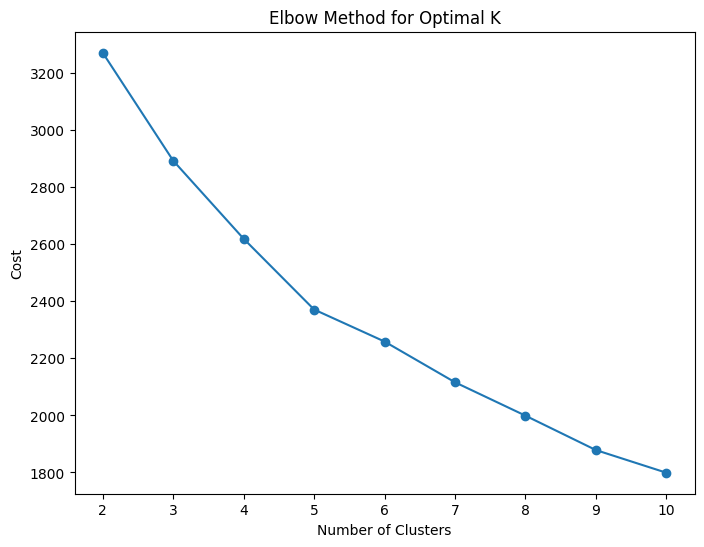

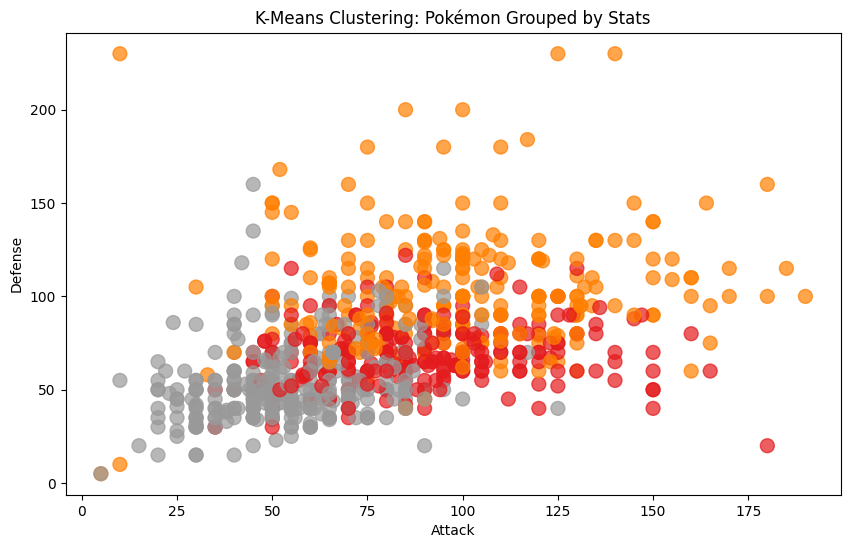

In [34]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("Sp. Atk", "Sp_Atk").withColumnRenamed("Sp. Def", "Sp_Def")
stats_cols = ["HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed"]

vector_assembler = VectorAssembler(inputCols=stats_cols, outputCol="features")
df_vector = vector_assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

cost = []
k_values = range(2, 11)  # start from 2, otherwise it'll raise an error

for k in k_values:
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    cost.append(model.summary.trainingCost)

plt.figure(figsize=(8, 6))
plt.plot(k_values, cost, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

optimal_k = 5  

# Train final KMeans model
kmeans = KMeans(featuresCol="scaled_features", k=optimal_k, seed=42)
model = kmeans.fit(df_scaled)
df_clustered = model.transform(df_scaled)

df_pandas = df_clustered.select("Attack", "Defense", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_pandas["Attack"], df_pandas["Defense"], c=df_pandas["prediction"], cmap="Set1", s=100, alpha=0.7)
plt.title('K-Means Clustering: Pokémon Grouped by Stats')
plt.xlabel('Attack')
plt.ylabel('Defense')
plt.show()


## 10. PCA (Principal Component Analysis)

- [x] **Check what the best features are in terms of predicting an outcome.**

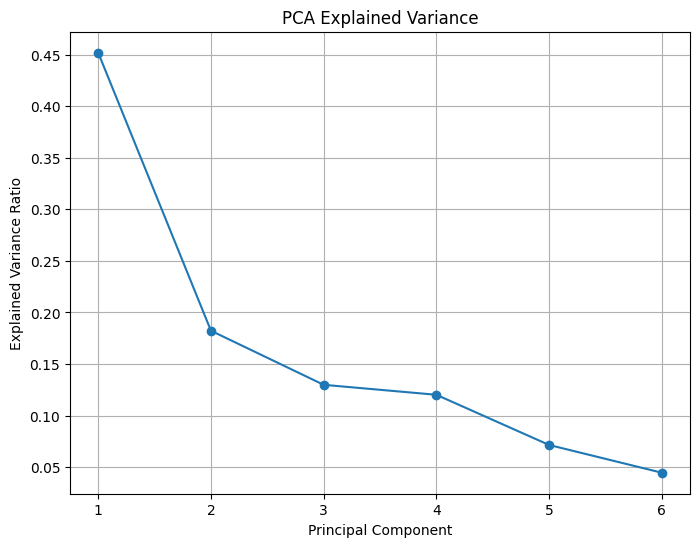

In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("PCA_Pokemon").getOrCreate()
df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("Sp. Atk", "Sp_Atk").withColumnRenamed("Sp. Def", "Sp_Def")
stats_cols = ["HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed"]

assembler = VectorAssembler(inputCols=stats_cols, outputCol="features")
df_vector = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

pca = PCA(k=6, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)

explained_variance = pca_model.explainedVariance.toArray()  

variance_df = pd.DataFrame({"Component": range(1, len(explained_variance) + 1), "Explained Variance": explained_variance})

plt.figure(figsize=(8, 6))
plt.plot(variance_df["Component"], variance_df["Explained Variance"], marker='o', linestyle="-")
plt.title("PCA Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.show()


## 11. Linear Regression

- [x] **What is the relationship between the Pokémon's stats (HP, Attack, Defense, Sp. Atk, Sp. Def, and Speed) and their Base Stat Total (BST)?**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName("LinearRegression_Pokemon").getOrCreate()
df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("Sp. Atk", "Sp_Atk").withColumnRenamed("Sp. Def", "Sp_Def")
df_BST = df.withColumn("BST", col("HP") + col("Attack") + col("Defense") + col("Sp_Atk") + col("Sp_Def") + col("Speed"))

feature_cols = ["HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed"]

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = vector_assembler.transform(df_BST).select("features", "BST")

df_vector = df_vector.withColumnRenamed("BST", "label")

train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select("features", "label", "prediction").show(5)

rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)

summary = lr_model.summary
print(f"Mean Absolute Error (MAE): {summary.meanAbsoluteError:.4f}")
print(f"Explained Variance: {summary.explainedVariance:.4f}")


+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[20.0,10.0,55.0,1...|  200|200.00000000000037|
|[20.0,40.0,15.0,3...|  205|205.00000000000014|
|[25.0,20.0,15.0,1...|  310| 309.9999999999998|
|[30.0,35.0,30.0,1...|  310|309.99999999999983|
|[30.0,45.0,135.0,...|  375|374.99999999999983|
+--------------------+-----+------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE): 0.0000
R² Score: 1.0000
Coefficients:  [1.0000000000000038,1.0000000000000009,1.0,0.9999999999999934,0.9999999999999973,1.0000000000000056]
Intercept:  0.0
Mean Absolute Error (MAE): 0.0000
Explained Variance: 14294.1480


## 12. Random Forest

- [x] **Use a random forest model to check which stats matter the most (including BST) for predicting if a Pokémon is Legendary or not.**

In [54]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report
import pandas as pd

spark = SparkSession.builder.appName("RandomForest_Pokemon").getOrCreate()
df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("Sp. Atk", "Sp_Atk").withColumnRenamed("Sp. Def", "Sp_Def")
df = df.withColumn("Legendary", col("Legendary").cast("integer"))

indexer = StringIndexer(inputCol="Legendary", outputCol="label")
df = indexer.fit(df).transform(df)

feature_cols = ["HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed", "Generation"]

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = vector_assembler.transform(df).select("features", "label")

train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxDepth=5, seed=42)

rf_model = rf.fit(train_data)

predictions = rf_model.transform(test_data)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

predictions_pd = predictions.select("label", "prediction").toPandas()

print("\nClassification Report:")
print(classification_report(predictions_pd["label"], predictions_pd["prediction"]))



Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       113
         1.0       0.75      0.38      0.50        16

    accuracy                           0.91       129
   macro avg       0.83      0.68      0.72       129
weighted avg       0.90      0.91      0.89       129



## 13. Logistic Regression

- [x] **Now apply the logistic regression model**

In [51]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report
import pandas as pd

spark = SparkSession.builder.appName("LogisticRegression_Pokemon").getOrCreate()

df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("Sp. Atk", "Sp_Atk").withColumnRenamed("Sp. Def", "Sp_Def")
df = df.withColumn("Legendary", col("Legendary").cast("integer"))

indexer = StringIndexer(inputCol="Legendary", outputCol="label")
df = indexer.fit(df).transform(df)

feature_cols = ['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation']

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = vector_assembler.transform(df).select("features", "label")  # Select only necessary columns

train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100)

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC AUC Score: {roc_auc:.4f}")

predictions_pd = predictions.select("label", "prediction").toPandas()

print("\n Classification Report:")
print(classification_report(predictions_pd["label"], predictions_pd["prediction"]))


ROC AUC Score: 0.6831

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       113
         1.0       0.86      0.38      0.52        16

    accuracy                           0.91       129
   macro avg       0.89      0.68      0.74       129
weighted avg       0.91      0.91      0.90       129



## 14. Gradient Boosting

- [x] **What is the probability that a Pokémon is Legendary based on its features (such as HP, Attack, Defense, Sp. Atk, Sp. Def, Speed, etc.)?**

In [52]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report
import pandas as pd

spark = SparkSession.builder.appName("GBT_Pokemon").getOrCreate()
df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("Sp. Atk", "Sp_Atk").withColumnRenamed("Sp. Def", "Sp_Def")
df = df.withColumn("Legendary", col("Legendary").cast("integer"))

indexer = StringIndexer(inputCol="Legendary", outputCol="label")
df = indexer.fit(df).transform(df)

feature_cols = ['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation']

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = vector_assembler.transform(df).select("features", "label")  # Select only necessary columns

train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100, maxDepth=5, seed=42)

gbt_model = gbt.fit(train_data)

predictions = gbt_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC AUC Score: {roc_auc:.4f}")

predictions_pd = predictions.select("label", "prediction").toPandas()

print("\nClassification Report:")
print(classification_report(predictions_pd["label"], predictions_pd["prediction"]))


ROC AUC Score: 0.8216

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       113
         1.0       0.69      0.69      0.69        16

    accuracy                           0.92       129
   macro avg       0.82      0.82      0.82       129
weighted avg       0.92      0.92      0.92       129



## 15. Neural Networks

- [x] **Use a Neural Network model to predict the Legendary status of a Pokémon based on its stats**

In [53]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("MLP_Pokemon").getOrCreate()
df = spark.read.csv("/kaggle/input/pokmon-dataset/pokemon_data.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("Sp. Atk", "Sp_Atk").withColumnRenamed("Sp. Def", "Sp_Def")
df = df.withColumn("Legendary", col("Legendary").cast("integer"))

indexer = StringIndexer(inputCol="Legendary", outputCol="label")
df = indexer.fit(df).transform(df)

feature_cols = ['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation']

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = vector_assembler.transform(df).select("features", "label")

train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

layers = [7, 6, 4, 2]

mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", layers=layers, maxIter=100)

mlp_model = mlp.fit(train_data)

mlp_predictions = mlp_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
mlp_accuracy = evaluator.evaluate(mlp_predictions)

print(f"Neural Network Accuracy: {mlp_accuracy:.4f}")

mlp_predictions.select("label", "prediction", "probability").show(10)


Neural Network Accuracy: 0.8760
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.98901257256465...|
|  0.0|       0.0|[0.97366029939286...|
|  0.0|       0.0|[0.67137086417658...|
|  0.0|       0.0|[0.67137086768810...|
|  0.0|       0.0|[0.98963013166899...|
|  0.0|       0.0|[0.98152371317586...|
|  0.0|       0.0|[0.98916474788386...|
|  0.0|       0.0|[0.97902262644370...|
|  0.0|       0.0|[0.98963289531296...|
|  0.0|       0.0|[0.97427518686802...|
+-----+----------+--------------------+
only showing top 10 rows



# SQL Queries (Using the PySpark Library)

- [x] **Rename the columns to be callable in SQL (substitute spaces an dots for underscores)**

In [47]:
df = df.withColumnRenamed("Sp. Atk", "Sp_Atk")
df = df.withColumnRenamed("Sp. Def", "Sp_Def")


df.show(5)

+---+--------------------+------+------+---+------+-------+------+------+-----+----------+---------+-----+
|  #|                Name|Type 1|Type 2| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|label|
+---+--------------------+------+------+---+------+-------+------+------+-----+----------+---------+-----+
|  1|           Bulbasaur| Grass|Poison| 45|    49|     49|    65|    65|   45|         1|        0|  0.0|
|  2|             Ivysaur| Grass|Poison| 60|    62|     63|    80|    80|   60|         1|        0|  0.0|
|  3|            Venusaur| Grass|Poison| 80|    82|     83|   100|   100|   80|         1|        0|  0.0|
|  3|VenusaurMega Venu...| Grass|Poison| 80|   100|    123|   122|   120|   80|         1|        0|  0.0|
|  4|          Charmander|  Fire|  NULL| 39|    52|     43|    60|    50|   65|         1|        0|  0.0|
+---+--------------------+------+------+---+------+-------+------+------+-----+----------+---------+-----+
only showing top 5 rows



- [x] **Use a SQL statement to return a table with Pokémon that have a BST>600**

In [50]:
df.createOrReplaceTempView("pokemon_data")

result = spark.sql("""
    select *, (hp + attack + defense + sp_atk + sp_def + speed) as bst
    from pokemon_data
    where (hp + attack + defense + sp_atk + sp_def + speed) > 600
""")

result.show()

spark.sql("""
    create or replace temp view bst as
    select *, (hp + attack + defense + sp_atk + sp_def + speed) as bst
    from pokemon_data
""")

result_2 = spark.sql("select * from bst where bst > 600")

result_2.show()


+---+--------------------+--------+--------+---+------+-------+------+------+-----+----------+---------+-----+---+
|  #|                Name|  Type 1|  Type 2| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|label|bst|
+---+--------------------+--------+--------+---+------+-------+------+------+-----+----------+---------+-----+---+
|  3|VenusaurMega Venu...|   Grass|  Poison| 80|   100|    123|   122|   120|   80|         1|        0|  0.0|625|
|  6|CharizardMega Cha...|    Fire|  Dragon| 78|   130|    111|   130|    85|  100|         1|        0|  0.0|634|
|  6|CharizardMega Cha...|    Fire|  Flying| 78|   104|     78|   159|   115|  100|         1|        0|  0.0|634|
|  9|BlastoiseMega Bla...|   Water|    NULL| 79|   103|    120|   135|   115|   78|         1|        0|  0.0|630|
|130|GyaradosMega Gyar...|   Water|    Dark| 95|   155|    109|    70|   130|   81|         1|        0|  0.0|640|
|142|AerodactylMega Ae...|    Rock|  Flying| 80|   135|     85|    70|    95|  1

The important SQL queries for this project were already created and are in the MySQL files available in the "Project 1: Pokémon" folder, so I will not repeat them here.

- [x] **Don't forget to stop the spark session**

In [63]:
spark.stop()